Modelo Economicos Agent Based Modeling (ABM)

Este es un ejemplo completo y didáctico de un modelo ABM económico en Python: un modelo de intercambio de riqueza (wealth-exchange) con propensión al ahorro y opción de impuesto + redistribución. 

Es un ABM clásico para mostrar desigualdad emergente (distribución, curva de Lorenz, Gini, top shares).

Supuestos ABM

Modelo ABM: Intercambio de riqueza con ahorro (CC model) + política fiscal 

Hay $N$ agentes con riqueza $𝑤_𝑖 ≥ 0$.

En cada paso:

Se elige una pareja aleatoria $(𝑖,𝑗)$.

Cada uno ahorra una fracción $𝑠$ de su riqueza.

El resto se pone en una “bolsa” y se reparte aleatoriamente.

Opcional (política): al final de cada “ronda” se aplica un impuesto proporcional $\tau$ y se redistribuye en suma fija a todos.

Regla de intercambio con ahorro común $𝑠$:

$𝑤_𝑖' = s𝑤_𝑖 + \varepsilon[(1-s)𝑤_𝑖 + (1-s)𝑤_𝑗]$

$𝑤_𝑗' = s𝑤_𝑗 + (1-\varepsilon)[(1-s)𝑤_𝑖 + (1-s)𝑤_𝑗]$

donde 
$$\varepsilon∼𝑈(0,1)$$


Imports y utilidades

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gini(x):
    """
    Coeficiente de Gini para vector x >= 0.
    """
    x = np.asarray(x, dtype=float)
    if np.any(x < 0):
        raise ValueError("Gini requiere x >= 0.")
    if np.allclose(x.sum(), 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    cumx = np.cumsum(x_sorted)
    # Fórmula estándar discreta
    g = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return g

def lorenz_curve(x):
    """
    Devuelve (p, L(p)) para la curva de Lorenz.
    p: proporción acumulada de población
    L: proporción acumulada de riqueza
    """
    x = np.asarray(x, dtype=float)
    x_sorted = np.sort(x)
    cumx = np.cumsum(x_sorted)
    total = cumx[-1] if cumx[-1] > 0 else 1.0
    L = np.insert(cumx / total, 0, 0.0)
    p = np.linspace(0, 1, len(L))
    return p, L

def top_share(x, q=0.10):
    """
    Participación de riqueza del top q (ej: q=0.10 => top 10%).
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    k = int(np.ceil((1 - q) * n))
    xs = np.sort(x)
    top = xs[k:]
    return top.sum() / xs.sum()


 Simulador ABM (ahorro homogéneo o heterogéneo + impuesto)

In [2]:
def simulate_wealth_exchange(
    N=2000,
    T=200,                 # número de "rondas" (cada ronda ~ N emparejamientos)
    w0=1.0,
    s=0.25,                # ahorro común (si s_i es None)
    s_i=None,              # ahorro heterogéneo por agente (array de tamaño N)
    tau=0.0,               # impuesto proporcional por ronda
    seed=123
):
    """
    ABM de intercambio de riqueza:
      - Emparejamiento aleatorio y reparto aleatorio del excedente no-ahorrado.
      - Opción de impuesto tau y redistribución lump-sum al final de cada ronda.

    Retorna:
      w: riqueza final (N,)
      stats: diccionario con series temporales (gini, top10, total)
    """
    rng = np.random.default_rng(seed)
    w = np.full(N, w0, dtype=float)

    if s_i is not None:
        s_i = np.asarray(s_i, dtype=float)
        if s_i.shape != (N,):
            raise ValueError("s_i debe tener tamaño (N,).")
        if np.any((s_i < 0) | (s_i >= 1)):
            raise ValueError("Cada s_i debe cumplir 0 <= s_i < 1.")
    else:
        if not (0 <= s < 1):
            raise ValueError("s debe cumplir 0 <= s < 1.")

    gini_series = []
    top10_series = []
    total_series = []

    for t in range(T):
        # Una "ronda": N emparejamientos
        for _ in range(N):
            i = rng.integers(0, N)
            j = rng.integers(0, N)
            while j == i:
                j = rng.integers(0, N)

            eps = rng.random()

            wi, wj = w[i], w[j]

            if s_i is None:
                si = sj = s
            else:
                si, sj = s_i[i], s_i[j]

            pool = (1 - si) * wi + (1 - sj) * wj
            w[i] = si * wi + eps * pool
            w[j] = sj * wj + (1 - eps) * pool

        # Política fiscal opcional: impuesto proporcional + redistribución uniforme
        if tau > 0:
            tax = tau * w
            revenue = tax.sum()
            w = w - tax + revenue / N

        # Estadísticas por ronda
        gini_series.append(gini(w))
        top10_series.append(top_share(w, q=0.10))
        total_series.append(w.sum())

    stats = {
        "gini": np.array(gini_series),
        "top10": np.array(top10_series),
        "total": np.array(total_series)
    }
    return w, stats


Correr un caso base y graficar dinámica

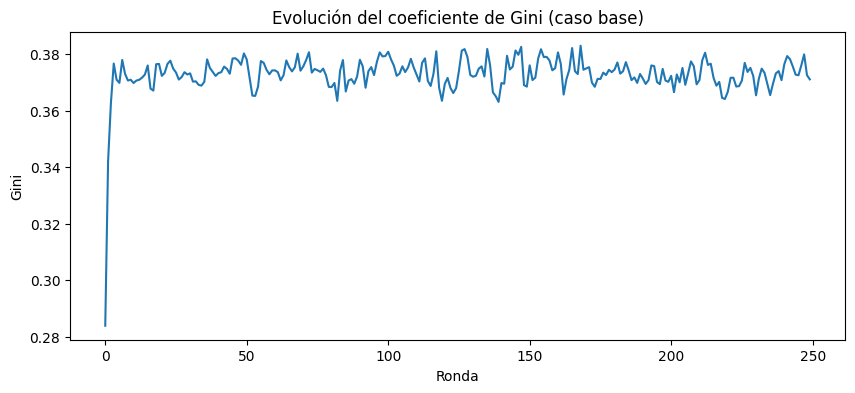

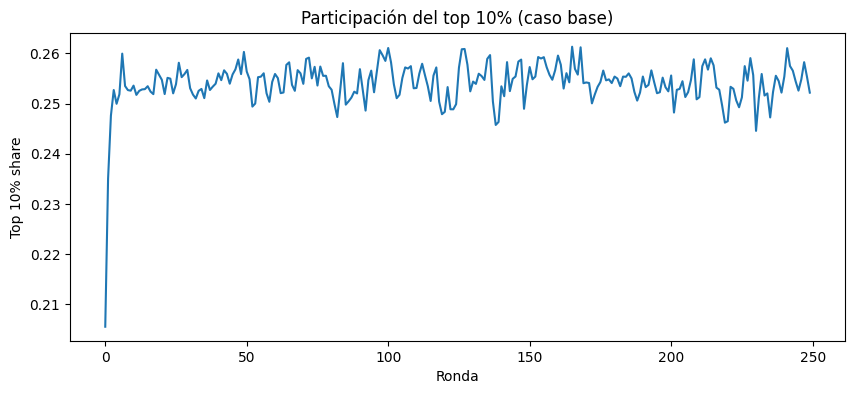

In [3]:
# Caso base: ahorro homogéneo s=0.25, sin impuestos
w_base, st_base = simulate_wealth_exchange(N=3000, T=250, s=0.25, tau=0.0, seed=7)

fig = plt.figure(figsize=(10,4))
plt.plot(st_base["gini"])
plt.title("Evolución del coeficiente de Gini (caso base)")
plt.xlabel("Ronda")
plt.ylabel("Gini")
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(st_base["top10"])
plt.title("Participación del top 10% (caso base)")
plt.xlabel("Ronda")
plt.ylabel("Top 10% share")
plt.show()


Distribución final + Lorenz

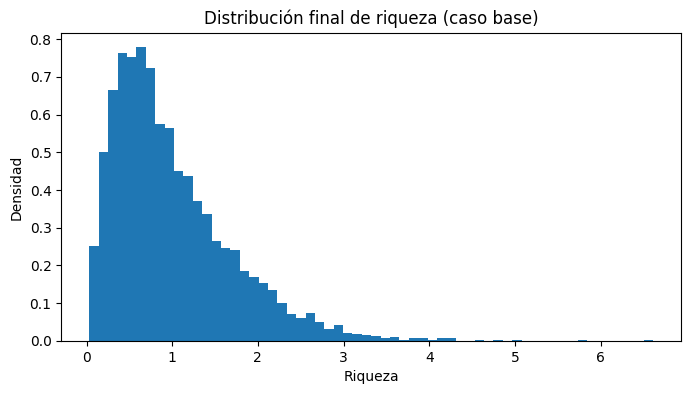

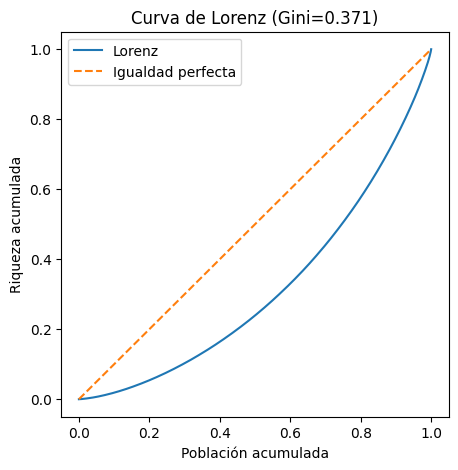

In [4]:
# Histograma de riqueza final
fig = plt.figure(figsize=(8,4))
plt.hist(w_base, bins=60, density=True)
plt.title("Distribución final de riqueza (caso base)")
plt.xlabel("Riqueza")
plt.ylabel("Densidad")
plt.show()

# Curva de Lorenz
p, L = lorenz_curve(w_base)
fig = plt.figure(figsize=(5,5))
plt.plot(p, L, label="Lorenz")
plt.plot([0,1], [0,1], linestyle="--", label="Igualdad perfecta")
plt.title(f"Curva de Lorenz (Gini={gini(w_base):.3f})")
plt.xlabel("Población acumulada")
plt.ylabel("Riqueza acumulada")
plt.legend()
plt.show()


Experimento: comparar ahorro y política fiscal

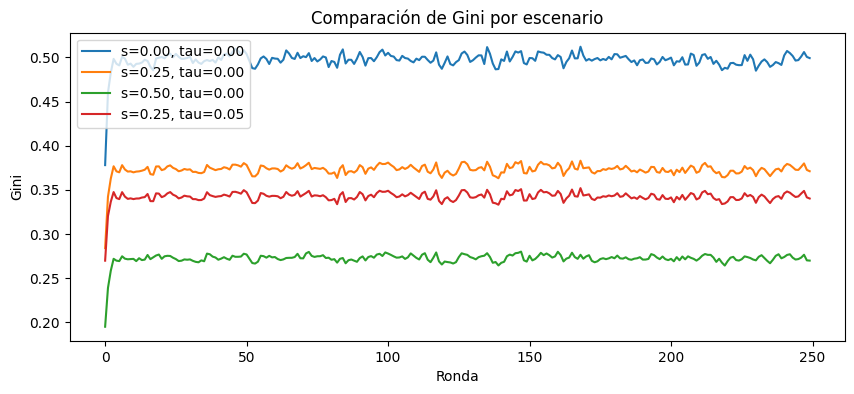

Gini final:
  s=0.00, tau=0.00  -> 0.499
  s=0.25, tau=0.00  -> 0.371
  s=0.50, tau=0.00  -> 0.270
  s=0.25, tau=0.05  -> 0.340

Top 10% share final:
  s=0.00, tau=0.00  -> 0.330
  s=0.25, tau=0.00  -> 0.252
  s=0.50, tau=0.00  -> 0.201
  s=0.25, tau=0.05  -> 0.237


In [5]:
# (A) Sin ahorro (s=0): tiende a desigualdad alta/volátil (y más "ruido")
w_s0, st_s0 = simulate_wealth_exchange(N=3000, T=250, s=0.0, tau=0.0, seed=7)

# (B) Más ahorro (s=0.50): típicamente cambia la forma de la distribución
w_s50, st_s50 = simulate_wealth_exchange(N=3000, T=250, s=0.50, tau=0.0, seed=7)

# (C) Caso base con impuesto y redistribución
w_tax, st_tax = simulate_wealth_exchange(N=3000, T=250, s=0.25, tau=0.05, seed=7)

fig = plt.figure(figsize=(10,4))
plt.plot(st_s0["gini"], label="s=0.00, tau=0.00")
plt.plot(st_base["gini"], label="s=0.25, tau=0.00")
plt.plot(st_s50["gini"], label="s=0.50, tau=0.00")
plt.plot(st_tax["gini"], label="s=0.25, tau=0.05")
plt.title("Comparación de Gini por escenario")
plt.xlabel("Ronda")
plt.ylabel("Gini")
plt.legend()
plt.show()

print("Gini final:")
print(f"  s=0.00, tau=0.00  -> {gini(w_s0):.3f}")
print(f"  s=0.25, tau=0.00  -> {gini(w_base):.3f}")
print(f"  s=0.50, tau=0.00  -> {gini(w_s50):.3f}")
print(f"  s=0.25, tau=0.05  -> {gini(w_tax):.3f}")

print("\nTop 10% share final:")
print(f"  s=0.00, tau=0.00  -> {top_share(w_s0):.3f}")
print(f"  s=0.25, tau=0.00  -> {top_share(w_base):.3f}")
print(f"  s=0.50, tau=0.00  -> {top_share(w_s50):.3f}")
print(f"  s=0.25, tau=0.05  -> {top_share(w_tax):.3f}")


Extensión potente: ahorro heterogéneo (cola tipo Pareto)

Gini final (heterogéneo): 0.428
Top 10% share final (heterogéneo): 0.295


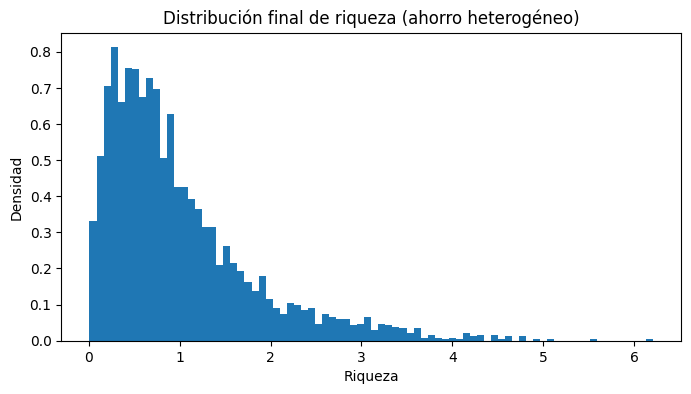

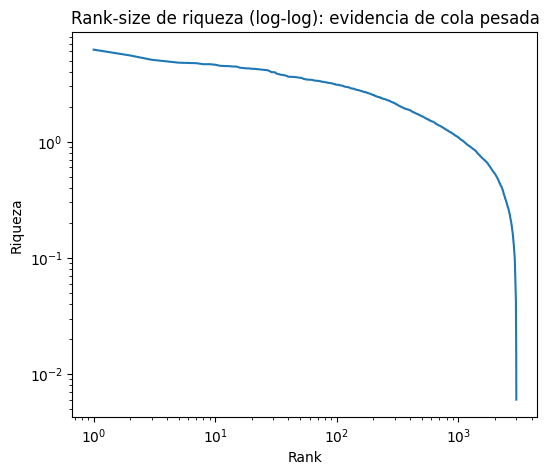

In [6]:
# Ahorro heterogéneo por agente (s_i ~ Uniforme[0, 0.9])
rng = np.random.default_rng(7)
s_i = rng.uniform(0.0, 0.9, size=3000)

w_het, st_het = simulate_wealth_exchange(N=3000, T=400, s_i=s_i, tau=0.0, seed=7)

print(f"Gini final (heterogéneo): {gini(w_het):.3f}")
print(f"Top 10% share final (heterogéneo): {top_share(w_het):.3f}")

# Histograma
fig = plt.figure(figsize=(8,4))
plt.hist(w_het, bins=80, density=True)
plt.title("Distribución final de riqueza (ahorro heterogéneo)")
plt.xlabel("Riqueza")
plt.ylabel("Densidad")
plt.show()

# Rank-size (log-log) para ver cola (si aparece)
w_sorted = np.sort(w_het)[::-1]
ranks = np.arange(1, len(w_sorted) + 1)

fig = plt.figure(figsize=(6,5))
plt.loglog(ranks, w_sorted)
plt.title("Rank-size de riqueza (log-log): evidencia de cola pesada")
plt.xlabel("Rank")
plt.ylabel("Riqueza")
plt.show()
